In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import argparse

# Hyperparameters

parser = argparse.ArgumentParser()

parser.add_argument("--in_channels",      type=int,   default=3,   help="number of channels on input")
parser.add_argument("--out_channels",     type=int,   default=3,   help="number of channels on output")

parser.add_argument("--unet_depth",       type=int,   default=7,   
                    help="number of downsamplings on unet: image shape should equal [2^depth, 2^depth]")
parser.add_argument("--unet_out_f",       type=int,   default=64,  help="n of filters in the last conv layer of unet")
parser.add_argument("--unet_conv_kernel", type=int,   default=4,   help="kernel size on unet conv layers")
parser.add_argument("--unet_conv_stride", type=int,   default=2,   help="stride on unet conv layers")
parser.add_argument("--unet_conv_pad",    type=int,   default=1,   help="padding on unet conv layers")
parser.add_argument("--unet_dropout",     type=float, default=0.5, help="dropout rate on unet")
parser.add_argument("--unet_lrelu_slope", type=float, default=0.2, help="slope of leaky relu on unet")

parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')

hps = parser.parse_args()

CIFAR-10 for dummy tests.

In [3]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

n_bins = 2**8  # 8 bits

transform = transforms.Compose([transforms.ToTensor(), 
                         lambda x: x + torch.zeros_like(x).uniform_(0., 1./n_bins)])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./.data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./.data', train=False,
                                       download=True, transform=transform)

    
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=10, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=10, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torchvision
from torchvision import datasets, transforms


class DummyGenerator():
    def __init__(self, hps=None, img_shape=(64,64)):
        self.img_height = img_shape[0]
        self.img_width = img_shape[1]

    
    # Feel free to improve...
        
    def generate_rectangles(self, set_size=1000):
        
        X = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        Y = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        
        vertices = np.array([np.random.choice(range(0, self.img_width // 2)), 
                               np.random.choice(range(self.img_width // 2, self.img_width))])
        
        coords_x = np.concatenate([np.arange(0, np.min(vertices - 2)), np.arange(np.max(vertices + 2), self.img_width)])
        coords_y = np.concatenate([np.arange(0, np.min(vertices - 2)), np.arange(np.max(vertices + 2), self.img_height)])
        
        Y[:, :, coords_x, :] = 0
        Y[:, :, :, coords_y] = 0
        
        lines_x = np.concatenate([coords_x, np.arange(np.min(vertices), np.max(vertices))])
        lines_y = np.concatenate([coords_y, np.arange(np.min(vertices), np.max(vertices))])
        
        h = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        v = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        
        h[:, :, lines_x, :] = 0
        v[:, :, :, lines_y] = 0
        
        X = h + v
        
        X[:, :, coords_x, :] = 0
        X[:, :, :, coords_y] = 0
        
        return X, Y
     
    

In [5]:
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms.functional as TF


class CustomTensorDataset(Dataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        
        
    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]
        
        x, y = self.transform(x, y)

        return x, y
    
    
    def transform(self, x, y):
        
        to_image = transforms.ToPILImage()
        to_tensor = transforms.ToTensor()
        
        x = to_image(x)
        y = to_image(y)
        
        angle = np.random.randint(-90, 90)
        translate = [np.random.randint(-20, 20), np.random.randint(-20, 20)]
        scale = np.random.uniform(1, 1.25)
        shear = np.random.randint(-30, 30)
        hflip = np.random.random() < 0.5
        
        x = TF.affine(x, angle, translate, scale, shear)
        y = TF.affine(y, angle, translate, scale, shear)
        
        if hflip:
            x = TF.hflip(x)
            y = TF.hflip(y)
        
        x = to_tensor(x)
        y = to_tensor(y)
        
        return x, y
        
        
    def __len__(self):
        return self.tensors[0].size(0)
    
    
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

In [6]:
import matplotlib.pyplot as plt

generator = DummyGenerator()
X, Y = generator.generate_rectangles()

dataset = CustomTensorDataset(tensors=(X, Y))
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [7]:
class UnetLayer(nn.Module):
    
    def __init__(self, hps, input_c, inner_f, outer_f, layer_type, sublayer, dropout=False):
        
        """
        Parameters:
            input_c (int)        : number of input channels
            inner_f (int)        : number of filters on inner layer
            outer_f (int)        : number of filters on outer layer
            layer_type (str)     : type of this layer, either 'default', 'innermost' or 'outermost'
            sublayer (UnetLayer) : sublayer in unet-hierarchy
            dropout (bool)       : use dropout layer?
        """
        
        super(UnetLayer, self).__init__()
        
        self.layer_type = layer_type
        
        down_conv = nn.Conv2d(input_c, inner_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
        down_relu = nn.LeakyReLU(hps.unet_lrelu_slope, inplace=True)
        down_norm = nn.BatchNorm2d(inner_f)
        
        up_relu = nn.ReLU(inplace=True)
        up_norm = nn.BatchNorm2d(outer_f)
        
        # Layers that are not innermost or outermost
        if layer_type == "default":
            up_conv = nn.ConvTranspose2d(inner_f * 2, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv, down_relu, down_norm]
            uplayers = [up_conv, up_relu, up_norm]
            
            if dropout:
                layer = downlayers + [sublayer] + uplayers + [nn.Dropout(hps.unet_dropout)]
            else:
                layer = downlayers + [sublayer] + uplayers
            
        if layer_type == "outermost":
            up_conv = nn.ConvTranspose2d(inner_f * 2, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv]
            uplayers = [up_conv, up_relu, nn.Tanh()]
            layer = downlayers + [sublayer] + uplayers
            
        if layer_type == "innermost":
            up_conv = nn.ConvTranspose2d(inner_f, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv, down_relu]
            uplayers = [up_conv, up_relu, up_norm]
            layer = downlayers + uplayers
        
        self.layer = nn.Sequential(*layer) 
        
        
    def forward(self, input):
        
        if self.layer_type == "outermost":
            return self.layer(input)
        else:
            return torch.cat([input, self.layer(input)], 1)
        
        

In [8]:
class Unet(nn.Module):
    """
    U-net (O. Ronneberger, P. Fischer, and T. Brox. (2015)) is utilized for generator.

    """
    def __init__(self, hps, input_c, output_c, outer_f, depth, dropout=False):
        
        """
        Parameters:
        
            input_c (int)  : number of input channels
            output_c (int) : number of output channels
            outer_f (int)  : number of filters on the last convolution
            depth (int)    : number of unet layers
            dropout (bool) : use dropout layer?
        """
        
        super(Unet, self).__init__()
        
        # Recursive construction:
        
        # Innermost layer
        layers = UnetLayer(hps, 8*outer_f, 8*outer_f, 8*outer_f, "innermost", None)
        
        # Default layers
        for i in range(depth - 5):
            layers = UnetLayer(hps, 8*outer_f, 8*outer_f, 8*outer_f, "default", layers, dropout=dropout)
        for i in range(3):
            # Gradual reduction of number of filters
            layers = UnetLayer(hps, (8//2**(i+1))*outer_f, (8//2**i)*outer_f, (8//2**(i+1))*outer_f, "default", layers)
        
        # Outermost layer
        self.layers = UnetLayer(hps, input_c, outer_f, output_c, "outermost", layers)
        
    def forward(self, input):
        return self.layers(input)
        

In [75]:
# Test forward pass with upsampled cifar-10

from torch.autograd import Variable

%store -r dataset

G = Unet(hps, hps.in_channels, hps.out_channels, hps.unet_out_f, hps.unet_depth, True)

u = torch.nn.Upsample(scale_factor=4)

x, _ = dataset[0]
x = x.unsqueeze(0)
x = Variable(x)
x = u(x)

hat_y = G(x)


no stored variable dataset


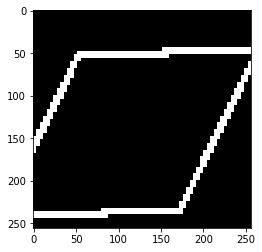

In [76]:
import matplotlib.pyplot as plt
x = x.squeeze(0)
plt.imshow(x.permute(1, 2, 0))

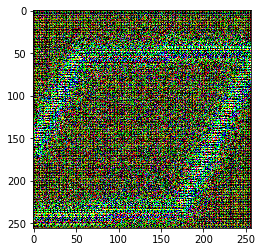

In [77]:
hat_y = hat_y.squeeze(0).detach()
plt.imshow(hat_y.permute(1, 2, 0))

In [60]:
"""
Discriminator used in training of the generator. Architecture and implementation according to [1].

[1] Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017).
Image-to-image translation with conditional adversarial networks.
In Proceedings of the IEEE conference on computer vision and pattern recognition
(pp. 1125-1134).
"""
class Discriminator(nn.Module):
    
    def __init__(self, input_c, input_f=64):
        super(Discriminator, self).__init__()

        padding = 1
        stride = 2
        ks = 4 # kernel size
        relu_slope = 0.2
        nof_layers = 3
        
        """
        Initialize a patchGAN discriminator
        with the following architecture:
            - C64-C128-C256-C512-output
        """
        # input layer, C64
        sequence = [nn.Conv2d(input_c, input_f, kernel_size=ks, stride=stride, padding=padding), nn.LeakyReLU(0.2, True)]
        
        # first hidden layer, C128
        m = 2**1 # filter multiplier
        m_previous = 1
        sequence += [
            nn.Conv2d(m_previous * input_f, m * input_f, kernel_size=ks, stride=stride),
            nn.BatchNorm2d(input_f * m), # Add normalization layer here
            nn.LeakyReLU(relu_slope, True)
        ]
        
        # second hidden layer, C256
        m_previous = m
        m = 2**2 # filter multiplier
        sequence += [
            nn.Conv2d(m_previous * input_f, m * input_f, kernel_size=ks, stride=stride),
            nn.BatchNorm2d(input_f * m), # Add normalization layer here
            nn.LeakyReLU(relu_slope, True)
        ]
        
        # third hidden layer, C512
        m_previous = m
        m = 2**nof_layers # filter multiplier
        sequence += [
            nn.Conv2d(m_previous * input_f, m * input_f, kernel_size=ks, stride=stride),
            nn.BatchNorm2d(input_f * m), # Add normalization layer here
            nn.LeakyReLU(relu_slope, True)
        ]
        
        # output layer with 1 output channel
        m_previous = m
        sequence += [nn.Conv2d(m_previous * input_f, 1, kernel_size=ks, stride=stride, padding=padding)]
        
        # model
        self.net = nn.Sequential(*sequence)
        
        
    def forward(self, input):
        return self.net(input)

In [73]:
# Test forward pass with upsampled cifar-10

from torch.autograd import Variable

D = Discriminator(input_c=6)

u = torch.nn.Upsample(scale_factor=4)

x, y = dataset[0]
xy = torch.cat((x, y), dim=0)
xy = xy.unsqueeze(0)
xy = Variable(xy)
xy = u(xy)

xy = D(xy)
xy.shape

torch.Size([1, 1, 7, 7])

In [74]:
x = x.unsqueeze(0)
hat_y = hat_y.unsqueeze(0)

x = u(x)

hat_xy = torch.cat((x, hat_y), dim=1)
hat_xy = Variable(hat_xy)


hat_xy = D(hat_xy)
hat_xy.shape

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 4 and 6 at /opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/TH/generic/THTensor.cpp:680